# Cleaning up WikiData Query Results

There are several issues with WikiData queries, one of the biggest is that some queries for different Node types will yield some of the same nodes.  These need to be reconciled before continuing (1 node type for one ID).

***Warning*** The cleanup pipeline is a result of my queries to WikiData at the time that I performed them.  As WikiData is constantaly changing, on future runs, changes may need to be peformed to get this notebook to complete successfully. I've outlined all decisions made to resolve conflicts in a way that hopefully allows future conflicts to be similarly resolved

In [1]:
import pandas as pd
from pathlib import Path
from data_tools import combine_nodes_and_edges
from data_tools.df_processing import combine_group_cols_on_char, split_col
from data_tools.wiki import xref_to_wd_item, get_curi_xrefs
from data_tools.plotting import count_plot_h

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
prev_dir = Path('../2_pipeline/01b_WikiData_Edges/out/').resolve()
nodes = pd.read_csv(prev_dir.joinpath('nodes.csv'), dtype=str)
edges = pd.read_csv(prev_dir.joinpath('edges.csv'), dtype=str)

# Reconcile Nodes

In [3]:
drop_idx = []
new_nodes = []
new_edges = []

In [4]:
duped_ids = nodes[nodes['id'].duplicated(keep=False)].sort_values('id')
duped_ids['id'].nunique()

1132

In [5]:
dup_type_map = duped_ids.groupby('id')['label'].apply(lambda x: ', '.join(sorted(list(x)))).to_dict()
duped_ids['duped_types'] = duped_ids['id'].map(dup_type_map)

In [6]:
dup_frac = duped_ids['duped_types'].value_counts() / duped_ids['duped_types'].value_counts().max()

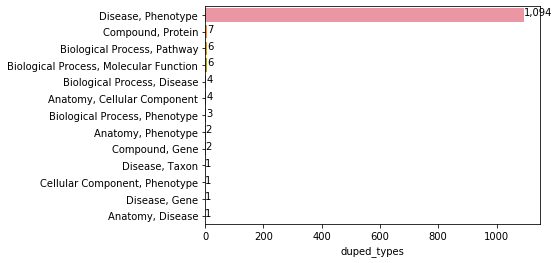

In [7]:
count_plot_h(duped_ids['duped_types'].value_counts() // 2)

In [8]:
# need all this to ensure consistent ordering each time notebook is run...
dt = (duped_ids['duped_types'].value_counts()
                              .to_frame()
                              .reset_index()
                              .sort_values(['duped_types', 'index'], ascending=(True, True))['index']
                              .tolist())

In [9]:
# Keep a consistent order for futuer iterations...

dt = ['Anatomy, Disease',
 'Cellular Component, Phenotype',
 'Disease, Gene',
 'Disease, Taxon',
 'Anatomy, Phenotype',
 'Compound, Gene',
 'Biological Process, Phenotype',
 'Anatomy, Cellular Component',
 'Biological Process, Disease',
 'Compound, Protein',
 'Biological Process, Molecular Function',
 'Biological Process, Pathway',
 'Disease, Phenotype']

In [10]:
dti = iter(dt)

In [11]:
this_dup = next(dti)
duped_ids.query('duped_types == @this_dup')

,id,name,label,xrefs,duped_types
767005,Q7170418,Persistent pupillary membrane,Anatomy,UBERON:0002269,"Anatomy, Disease"
362389,Q7170418,Persistent pupillary membrane,Disease,UMLS:C0344541,"Anatomy, Disease"


This is a Disease, but it is located in anatomy... 

In [12]:
xid = duped_ids.query('duped_types == @this_dup and label == "Anatomy"')['xrefs'].values[0]
qid = xref_to_wd_item(nodes, xid, always_list=True)
nodes.query('id in @qid')

,id,name,label,xrefs
362389,Q7170418,Persistent pupillary membrane,Disease,UMLS:C0344541
767005,Q7170418,Persistent pupillary membrane,Anatomy,UBERON:0002269


No other WD items have that UBERON identifier. Drop the Anatomy, but add a new edge

In [13]:
def xrefs_to_new_nodes(combined_nodes, new_names=None):
    add_nodes = combined_nodes[['xrefs', 'name', 'label']].rename(columns={'xrefs': 'id'}).copy()
    if new_names is not None:
        add_nodes['name'] = new_names
    return add_nodes
    
def xrefs_to_new_edges(combined_nodes, start_col, end_col, semmantics):
    # ensure we've got a dataframe (single index will return series)
    if type(combined_nodes) == pd.Series:
        combined_nodes = combined_nodes.to_frame().T
    
    add_edges = combined_nodes[['xrefs', 'id']].rename(columns={start_col: 'start_id', end_col: 'end_id'}).copy()
    add_edges['type'] = semmantics
    add_edges['dsrc_type'] = 'computed'
    add_edges['comp_type'] = 'split'
    return add_edges.loc[:, ['start_id','end_id','type','dsrc_type','comp_type']]

In [14]:
def combine_xrefs_and_set_label(combined_nodes, label):
    add_nodes = combine_group_cols_on_char(combined_nodes, ['id'], ['xrefs'], prog=False)
    add_nodes['label'] = label
    add_nodes = add_nodes.drop('duped_types', axis=1)
    return add_nodes

In [15]:
# Prepare to drop the bad edge
to_drop = [duped_ids.query('duped_types == @this_dup and label == "Anatomy"').index.values[0]]
drop_idx += to_drop

# Add the new node
add_node = xrefs_to_new_nodes(duped_ids.loc[to_drop], 'Pupillary membrane')
new_nodes.append(add_node)

# And add the edge
add_edge = xrefs_to_new_edges(duped_ids.loc[to_drop], 'id', 'xrefs', 'localized_to')
new_edges.append(add_edge)

In [16]:
this_dup = next(dti)
duped_ids.query('duped_types == @this_dup')

,id,name,label,xrefs,duped_types
631355,Q767442,neurofibrillary tangle,Phenotype,HP:0002185|MESH:D016874,"Cellular Component, Phenotype"
764879,Q767442,neurofibrillary tangle,Cellular Component,GO:0097418,"Cellular Component, Phenotype"


While a valid phenotype, seems ot have more incommon with the cell component...

In [17]:
this_drop = duped_ids.query('duped_types == @this_dup').index.tolist()
drop_idx += this_drop
new_nodes.append(combine_xrefs_and_set_label(duped_ids.loc[this_drop], 'Cellular Component'))

In [18]:
this_dup = next(dti)
duped_ids.query('duped_types == @this_dup')

,id,name,label,xrefs,duped_types
348508,Q14913011,MVK,Disease,MONDO:0012481|OMIM:175900|OMIM:251170|OMIM:260...,"Disease, Gene"
632298,Q14913011,MVK,Gene,ENSG:ENSG00000110921|HGNC:7530|NCBIGene:4598|O...,"Disease, Gene"


This is a Gene... look for this MONDO ID elsewhere...

In [19]:
xid = duped_ids.query('duped_types == @this_dup and label == "Disease"')['xrefs'].values[0]
xid = [x for x in xid.split('|') if x.startswith('MONDO:')][0]
mondo_ids = xref_to_wd_item(nodes, xid, always_list=True)
nodes.query('id in @mondo_ids')

,id,name,label,xrefs
348508,Q14913011,MVK,Disease,MONDO:0012481|OMIM:175900|OMIM:251170|OMIM:260...
356543,Q3043158,mevalonic aciduria,Disease,DOID:0050452|MESH:D054078|MONDO:0012481|OMIM:6...
632298,Q14913011,MVK,Gene,ENSG:ENSG00000110921|HGNC:7530|NCBIGene:4598|O...


The Disease already exists, prepare to drop and ensure that the edge between the two exists

In [20]:
to_drop = duped_ids.query('duped_types == @this_dup and label == "Disease"').index.values[0]
drop_idx.append(to_drop)

sid, eid = nodes.query('id in @mondo_ids')['id'].unique()
edges.query('(start_id == @sid and end_id == @eid) or (start_id == @eid and end_id == @sid)')

,start_id,end_id,type,dsrc_type,comp_type
3681823,Q14913011,Q3043158,associated_with,crowd_sourced,NaN


In [21]:
this_dup = next(dti)
duped_ids.query('duped_types == @this_dup')

,id,name,label,xrefs,duped_types
116,Q184627,Human papillomavirus infection,Taxon,NaN,"Disease, Taxon"
349277,Q184627,Human papillomavirus infection,Disease,DOID:11166|MESH:D030361|MONDO:0005161|UMLS:C03...,"Disease, Taxon"


HPV infection is not a taxon, but rather a disease. It has a cause of ... hpv

In [22]:
drop_idx += duped_ids.query('duped_types == @this_dup and label == "Taxon"').index.tolist()

In [23]:
this_dup = next(dti)
duped_ids.query('duped_types == @this_dup')

,id,name,label,xrefs,duped_types
629667,Q1174313,Diastema,Phenotype,HP:0000699|MESH:D003970,"Anatomy, Phenotype"
765057,Q1174313,Diastema,Anatomy,MESH:D003970|UBERON:0012111,"Anatomy, Phenotype"
630716,Q356002,anterior pituitary,Phenotype,HP:0010625|MESH:D010903,"Anatomy, Phenotype"
766082,Q356002,anterior pituitary,Anatomy,MESH:D010903|UBERON:0002196,"Anatomy, Phenotype"


Both well annotated, but seeming more like anatomy nodes... will keep the xrefs

In [24]:
this_drop = duped_ids.query('duped_types == @this_dup').index.tolist()
drop_idx += this_drop
new_nodes.append(combine_xrefs_and_set_label(duped_ids.loc[this_drop], 'Anatomy'))

In [25]:
this_dup = next(dti)
duped_ids.query('duped_types == @this_dup')

,id,name,label,xrefs,duped_types
632211,Q14911781,ALDH2,Gene,ENSG:ENSG00000111275|HGNC:404|NCBIGene:217|OMI...,"Compound, Gene"
364436,Q14911781,ALDH2,Compound,NaN,"Compound, Gene"
510353,Q418553,NGB,Compound,NaN,"Compound, Gene"
689440,Q418553,NGB,Gene,ENSG:ENSG00000165553|HGNC:14077|NCBIGene:58157...,"Compound, Gene"


Two compounds with no xrefs... Just drop the compound version

In [26]:
drop_idx = drop_idx + duped_ids.query('duped_types == @this_dup and label == "Compound"').index.tolist()

In [27]:
this_dup = next(dti)
duped_ids.query('duped_types == @this_dup')

,id,name,label,xrefs,duped_types
629822,Q14864096,skeletal muscle atrophy,Phenotype,HP:0003202,"Biological Process, Phenotype"
731651,Q14864096,skeletal muscle atrophy,Biological Process,GO:0014732,"Biological Process, Phenotype"
629852,Q15322281,chromosome breakage,Phenotype,HP:0003220|MESH:D019457,"Biological Process, Phenotype"
735264,Q15322281,chromosome breakage,Biological Process,GO:0031052,"Biological Process, Phenotype"
630722,Q35831,sleep,Phenotype,HP:0002329|MESH:D012890,"Biological Process, Phenotype"
759971,Q35831,sleep,Biological Process,GO:0030431,"Biological Process, Phenotype"


Phenotypes and biological Processes... GO is a really tight annotaiton system, so don't really want to remove... will keep the pheno annotations...

In [28]:
this_drop = duped_ids.query('duped_types == @this_dup').index.tolist()
drop_idx += this_drop
new_nodes.append(combine_xrefs_and_set_label(duped_ids.loc[this_drop], 'Biological Process'))

In [29]:
this_dup = next(dti)
duped_ids.query('duped_types == @this_dup')

,id,name,label,xrefs,duped_types
765476,Q187388,myelin,Anatomy,UBERON:0000345,"Anatomy, Cellular Component"
761178,Q187388,myelin,Cellular Component,GO:0043209,"Anatomy, Cellular Component"
766332,Q4736445,climbing fiber,Anatomy,UBERON:2002185,"Anatomy, Cellular Component"
764718,Q4736445,climbing fiber,Cellular Component,GO:0044301,"Anatomy, Cellular Component"
764882,Q776995,neuromuscular junction,Cellular Component,GO:0031594,"Anatomy, Cellular Component"
767185,Q776995,neuromuscular junction,Anatomy,MESH:D009469|UBERON:0001029,"Anatomy, Cellular Component"
767237,Q809756,basal lamina,Anatomy,UBERON:0000482|UBERON:0003957,"Anatomy, Cellular Component"
764892,Q809756,basal lamina,Cellular Component,GO:0005605,"Anatomy, Cellular Component"


These are all Cell Component Terms... `myelin` and `climbing fiber` have proper uberon annotations, but the remainder are either xref'd to a (close but) incorrect term, or xref to obsolete UBERON terms.

In [30]:
# Get rid of the conflicting nodes
this_drop = duped_ids.query('duped_types == @this_dup and label == "Anatomy"').index.tolist()
drop_idx = drop_idx + this_drop

# Keep the two ok nodes
keep_xrefs = duped_ids.loc[this_drop].query('name in {!r}'.format(['myelin', 'climbing fiber']))
add_nodes = xrefs_to_new_nodes(keep_xrefs)
new_nodes.append(add_nodes)

# Add links between the two concepts
add_edges = xrefs_to_new_edges(keep_xrefs, 'id', 'xrefs', 'localized_to')
new_edges.append(add_edge)

In [31]:
this_dup = next(dti)
duped_ids.query('duped_types == @this_dup')

,id,name,label,xrefs,duped_types
357989,Q42982,type I hypersensitivity,Disease,DOID:1205|UMLS:C0020517,"Biological Process, Disease"
760064,Q42982,type I hypersensitivity,Biological Process,GO:0016068,"Biological Process, Disease"
760450,Q5898315,type III hypersensitivity,Biological Process,GO:0001802,"Biological Process, Disease"
361254,Q5898315,type III hypersensitivity,Disease,DOID:1557|MESH:D007105|MONDO:0007004|UMLS:C002...,"Biological Process, Disease"
361280,Q5958765,hypersensitivity,Disease,DOID:0060056|MESH:D006967|MONDO:0000605|UMLS:C...,"Biological Process, Disease"
760451,Q5958765,hypersensitivity,Biological Process,GO:0002524,"Biological Process, Disease"
760592,Q7860879,type IV hypersensitivity,Biological Process,GO:0001806,"Biological Process, Disease"
362771,Q7860879,type IV hypersensitivity,Disease,DOID:2916|MESH:D006968|UMLS:C0021070,"Biological Process, Disease"


Definitely instances of both.. need to split into Biological Processes and Diseases

In [32]:
this_drop = duped_ids.query('duped_types == @this_dup and label == "Biological Process"').index.tolist()
drop_idx = drop_idx + this_drop

new_nodes.append(xrefs_to_new_nodes(duped_ids.loc[this_drop]))
new_edges.append(xrefs_to_new_edges(duped_ids.loc[this_drop], 'xrefs', 'id', 'causes'))

In [33]:
this_dup = next(dti)
duped_ids.query('duped_types == @this_dup')

,id,name,label,xrefs,duped_types
98468,Q15709005,Botulinum Toxin Type B,Protein,UniProt:P10844,"Compound, Protein"
366223,Q15709005,Botulinum Toxin Type B,Compound,CHEMBL:CHEMBL1201569|DB:00042|KEGG:D02735|MESH...,"Compound, Protein"
367096,Q170617,glucagon,Compound,CHEBI:5391|CHEMBL:CHEMBL266481|DB:00040|KEGG:C...,"Compound, Protein"
690576,Q170617,glucagon,Protein,UniProt:P01275,"Compound, Protein"
440287,Q27205,fibrin,Compound,CHEBI:5054|KEGG:C00290|MESH:D005337|PCID:439199,"Compound, Protein"
714506,Q27205,fibrin,Protein,NaN,"Compound, Protein"
714634,Q2993328,beta-endorphin,Protein,UniProt:P01189,"Compound, Protein"
506277,Q2993328,beta-endorphin,Compound,CHEBI:10415|CHEMBL:CHEMBL2369948|KEGG:C02210|M...,"Compound, Protein"
714801,Q4063639,alpha-melanocyte-stimulating hormone,Protein,UniProt:P01189,"Compound, Protein"
508209,Q4063639,alpha-melanocyte-stimulating hormone,Compound,CHEMBL:CHEMBL214332|MESH:D000521|PCID:44273719...,"Compound, Protein"


These are all Polypeptides... However, they have numerous chemical annotations...

In [34]:
this_drop = duped_ids.query('duped_types == @this_dup').index.tolist()
drop_idx += this_drop
new_nodes.append(combine_xrefs_and_set_label(duped_ids.loc[this_drop], 'Protein'))

In [35]:
this_dup = next(dti)
duped_ids.query('duped_types == @this_dup')

,id,name,label,xrefs,duped_types
736129,Q21101059,ubiquitin protein ligase activity involved in ...,Biological Process,GO:1904264,"Biological Process, Molecular Function"
720635,Q21101059,ubiquitin protein ligase activity involved in ...,Molecular Function,GO:1904264,"Biological Process, Molecular Function"
741315,Q22243254,"transcription factor activity, estrogen-activa...",Biological Process,GO:0038053,"Biological Process, Molecular Function"
723267,Q22243254,"transcription factor activity, estrogen-activa...",Molecular Function,GO:0038053,"Biological Process, Molecular Function"
725694,Q22320077,"glucan endo-1,3-beta-D-glucosidase activity in...",Molecular Function,GO:0072317,"Biological Process, Molecular Function"
758369,Q22320077,"glucan endo-1,3-beta-D-glucosidase activity in...",Biological Process,GO:0072317,"Biological Process, Molecular Function"
758384,Q22323783,ubiquitin protein ligase activity involved in ...,Biological Process,GO:1904822,"Biological Process, Molecular Function"
727717,Q22323783,ubiquitin protein ligase activity involved in ...,Molecular Function,GO:1904822,"Biological Process, Molecular Function"
728900,Q22325139,mitochondrial RNA polymerase transcription fac...,Molecular Function,GO:0001142,"Biological Process, Molecular Function"
758411,Q22325139,mitochondrial RNA polymerase transcription fac...,Biological Process,GO:0001142,"Biological Process, Molecular Function"


These are all obsolete terms. Drop em all.

In [36]:
drop_idx = drop_idx + duped_ids.query('duped_types == @this_dup').index.tolist()

In [37]:
this_dup = next(dti)
duped_ids.query('duped_types == @this_dup')

,id,name,label,xrefs,duped_types
731064,Q14859896,cellular amino acid metabolic process,Biological Process,GO:0006520,"Biological Process, Pathway"
716006,Q14859896,cellular amino acid metabolic process,Pathway,NaN,"Biological Process, Pathway"
731716,Q14864262,protein metabolic process,Biological Process,GO:0019538,"Biological Process, Pathway"
716007,Q14864262,protein metabolic process,Pathway,NaN,"Biological Process, Pathway"
716008,Q14866112,apoptotic signaling pathway,Pathway,NaN,"Biological Process, Pathway"
732321,Q14866112,apoptotic signaling pathway,Biological Process,GO:0097190,"Biological Process, Pathway"
759448,Q2792936,lipid metabolism,Biological Process,GO:0006629,"Biological Process, Pathway"
716014,Q2792936,lipid metabolism,Pathway,NaN,"Biological Process, Pathway"
718927,Q5768379,Hippo signaling pathway,Pathway,NaN,"Biological Process, Pathway"
760435,Q5768379,Hippo signaling pathway,Biological Process,GO:0035329,"Biological Process, Pathway"


These pathways have no Xrefs, so we will keep them as GO biological Processes.

In [38]:
qr = duped_ids.query('duped_types == @this_dup')
drop_idx = drop_idx + qr[qr['xrefs'].isnull()].index.tolist()

In [39]:
this_dup = next(dti)
duped_ids.query('duped_types == @this_dup')

,id,name,label,xrefs,duped_types
629561,Q1016605,Burkitt lymphoma,Phenotype,HP:0030080|MESH:D002051|OMIM:113970,"Disease, Phenotype"
347783,Q1016605,Burkitt lymphoma,Disease,DOID:8584|MESH:D002051|OMIM:113970|UMLS:C0006413,"Disease, Phenotype"
629562,Q101971,wart,Phenotype,HP:0200043|MESH:D014860,"Disease, Phenotype"
347788,Q101971,wart,Disease,MESH:D014860|UMLS:C3665596,"Disease, Phenotype"
629565,Q1027995,pyloric stenosis,Phenotype,HP:0002021|MESH:D011707,"Disease, Phenotype"
...,...,...,...,...,...
631504,Q979168,cerebral edema,Phenotype,HP:0002181|MESH:D001929,"Disease, Phenotype"
363210,Q994859,homocystinuria,Disease,DOID:9263|MESH:D006712|MONDO:0004737|OMIM:2362...,"Disease, Phenotype"
631507,Q994859,homocystinuria,Phenotype,HP:0002156|MESH:D006712|OMIM:236200|OMIM:236250,"Disease, Phenotype"
631508,Q994942,bruxism,Phenotype,HP:0003763|MESH:D002012,"Disease, Phenotype"


### Disease and Phenotype...

Too many to do any kind of a blanket merge...  We will:
1. Convert those with an HPO id but no DOID to a Phenotype
2. Covert those with no HPO id but with a DOID to a Disease
3. See how many have both...

#### Conflicts with no Disease Xref

In [40]:
pheno_dis = duped_ids.query('duped_types == @this_dup').copy()

qr = pheno_dis.query('label == "Disease"')
no_d_xref = qr[qr['xrefs'].isnull()]['id'].tolist()

duped_ids.query('id in @no_d_xref')

,id,name,label,xrefs,duped_types
348431,Q143607,bleeding gums,Disease,NaN,"Disease, Phenotype"
629795,Q143607,bleeding gums,Phenotype,NaN,"Disease, Phenotype"
629915,Q1640998,hyperkeratosis,Phenotype,HP:000962,"Disease, Phenotype"
348763,Q1640998,hyperkeratosis,Disease,NaN,"Disease, Phenotype"
630017,Q18054140,collapse,Phenotype,NaN,"Disease, Phenotype"
349207,Q18054140,collapse,Disease,NaN,"Disease, Phenotype"
352791,Q188611,hypomania,Disease,NaN,"Disease, Phenotype"
630149,Q188611,hypomania,Phenotype,NaN,"Disease, Phenotype"
357338,Q3317827,disability affecting intellectual abilities,Disease,NaN,"Disease, Phenotype"
630692,Q3317827,disability affecting intellectual abilities,Phenotype,HP:0001249,"Disease, Phenotype"


In [41]:
this_drop = duped_ids.query('id in @no_d_xref').index.tolist()
drop_idx += this_drop

pheno_dis = pheno_dis.drop(this_drop)

In [42]:
new_nodes.append(combine_xrefs_and_set_label(duped_ids.loc[this_drop], 'Phenotype'))

Mostly bad have no xrefs, 2 with phenotypes. I think we can safely merge these to phenotypes

#### Conflicts with no Pheno Xref

In [43]:
qr = pheno_dis.query('label == "Phenotype"')
no_p_xref = qr[qr['xrefs'].isnull()]['id'].tolist()

duped_ids.query('id in @no_p_xref')

,id,name,label,xrefs,duped_types
630475,Q2466723,gummatous syphilis,Phenotype,NaN,"Disease, Phenotype"
355256,Q2466723,gummatous syphilis,Disease,DOID:0050584|MONDO:0000363,"Disease, Phenotype"
630810,Q420915,acroparesthesia,Phenotype,NaN,"Disease, Phenotype"
357912,Q420915,acroparesthesia,Disease,UMLS:C1332141,"Disease, Phenotype"


gummatous syphilis is a Disease, but the acroparesthesia appears to be a Phenotype

In [44]:
this_drop = duped_ids.query('id in @no_p_xref').index.tolist()
drop_idx += this_drop

new_nodes.append(duped_ids.loc[this_drop].query('name == "gummatous syphilis" and label == "Disease"'))
new_nodes.append(duped_ids.loc[this_drop].query('name == "acroparesthesia" and label == "Phenotype"'))

pheno_dis = pheno_dis.drop(this_drop)

#### Now for conflicts with no HPO xref

In [45]:
qr = pheno_dis.query('label == "Phenotype"').dropna(subset=['xrefs'])
no_hpo_xref = qr[~qr['xrefs'].str.contains('HP:')]['id'].tolist()
duped_ids.query('id in @no_hpo_xref')

,id,name,label,xrefs,duped_types
348784,Q1644260,hearing disorder,Disease,DOID:12226|MESH:D006311|MONDO:0021945|UMLS:C02...,"Disease, Phenotype"
629932,Q1644260,hearing disorder,Phenotype,MESH:D006311,"Disease, Phenotype"
352938,Q189331,heart arrhythmia,Disease,MESH:D001145|MONDO:0007263|MONDO:0016347|OMIM:...,"Disease, Phenotype"
630150,Q189331,heart arrhythmia,Phenotype,MESH:D001145|OMIM:115000,"Disease, Phenotype"
630175,Q19000619,urination disorder,Phenotype,MESH:D014555,"Disease, Phenotype"
353907,Q19000619,urination disorder,Disease,DOID:578|MESH:D014555,"Disease, Phenotype"
354822,Q21110016,corneal damage,Disease,MESH:D065306,"Disease, Phenotype"
630268,Q21110016,corneal damage,Phenotype,MESH:D065306,"Disease, Phenotype"
355195,Q2365426,Acneiform eruption,Disease,DOID:4399|MESH:D017486|MONDO:0006521|UMLS:C017...,"Disease, Phenotype"
630452,Q2365426,Acneiform eruption,Phenotype,MESH:D017486,"Disease, Phenotype"


`corneal damage` is a phenotype, remainder can be classified as a disease.

In [46]:
this_drop = duped_ids.query('id in @no_hpo_xref').index.tolist()
drop_idx += this_drop

new_nodes.append(duped_ids.loc[this_drop].query('name == "corneal damage" and label == "Phenotype"'))
new_nodes.append(combine_xrefs_and_set_label(duped_ids.loc[this_drop].query('name != "corneal damage"'), 'Disease'))

pheno_dis = pheno_dis.drop(this_drop)

#### Conflicts with no DO xref

In [47]:
qr = pheno_dis.query('label == "Disease"').dropna(subset=['xrefs'])
no_doid_xref = qr[~qr['xrefs'].str.contains('DOID:')]['id'].tolist()
duped_ids.query('id in @no_doid_xref')

,id,name,label,xrefs,duped_types
629562,Q101971,wart,Phenotype,HP:0200043|MESH:D014860,"Disease, Phenotype"
347788,Q101971,wart,Disease,MESH:D014860|UMLS:C3665596,"Disease, Phenotype"
347811,Q1036696,hypothermia,Disease,MESH:D007035|UMLS:C0020672,"Disease, Phenotype"
629570,Q1036696,hypothermia,Phenotype,HP:0002045|MESH:D007035,"Disease, Phenotype"
347843,Q105688,hypoxia,Disease,MESH:D000860|UMLS:C0700292,"Disease, Phenotype"
...,...,...,...,...,...
631484,Q955454,Coxa valga,Phenotype,HP:0002673|MESH:D060906,"Disease, Phenotype"
631488,Q961331,pilonidal cyst,Phenotype,HP:0010769|MESH:D010864|OMIM:173000,"Disease, Phenotype"
363177,Q961331,pilonidal cyst,Disease,MESH:D010864|MONDO:0008249|OMIM:173000|UMLS:C0...,"Disease, Phenotype"
631494,Q970208,liver failure,Phenotype,HP:0001399|MESH:D017093,"Disease, Phenotype"


Lots of examples here... This small smattering looks like Primarily phenotypes... 

Lets take a bigger sample to make sure

In [48]:
duped_ids.query('id in @no_doid_xref').drop_duplicates(subset=['id']).sample(40)

,id,name,label,xrefs,duped_types
354729,Q2074059,oculomotor apraxia,Disease,MONDO:0020258,"Disease, Phenotype"
629718,Q1320276,hypovolemia,Phenotype,HP:0011106|MESH:D020896,"Disease, Phenotype"
348195,Q1274018,Schimmelpenning syndrome,Disease,MESH:D054000|MONDO:0008097|OMIM:163200|UMLS:C0...,"Disease, Phenotype"
631488,Q961331,pilonidal cyst,Phenotype,HP:0010769|MESH:D010864|OMIM:173000,"Disease, Phenotype"
360156,Q5572455,Glutaric aciduria,Disease,MONDO:0000129|UMLS:C0268594,"Disease, Phenotype"
630571,Q296104,Activated protein C resistance,Phenotype,HP:0012175|MESH:D020016|OMIM:188055,"Disease, Phenotype"
348620,Q1550742,genu varum,Disease,MESH:D056305|UMLS:C0544755,"Disease, Phenotype"
358311,Q484797,anal fissure,Disease,MESH:D005401|UMLS:C0016167,"Disease, Phenotype"
362889,Q826918,bone cyst,Disease,MESH:D001845|UMLS:C0005937,"Disease, Phenotype"
629723,Q1324592,laryngospasm,Phenotype,HP:0006511|MESH:D007826,"Disease, Phenotype"


Lots of HPO Xrefs on these, most look like phenotypes, so we will coerce them all to phenotypes, while maintaining the original Xref

In [49]:
this_drop = duped_ids.query('id in @no_doid_xref').index.tolist()
drop_idx += this_drop

new_nodes.append(combine_xrefs_and_set_label(duped_ids.loc[this_drop], 'Phenotype'))

pheno_dis = pheno_dis.drop(this_drop)

What's left should have both DO and HPO xref identifiers

In [50]:
pheno_dis

,id,name,label,xrefs,duped_types
629561,Q1016605,Burkitt lymphoma,Phenotype,HP:0030080|MESH:D002051|OMIM:113970,"Disease, Phenotype"
347783,Q1016605,Burkitt lymphoma,Disease,DOID:8584|MESH:D002051|OMIM:113970|UMLS:C0006413,"Disease, Phenotype"
629565,Q1027995,pyloric stenosis,Phenotype,HP:0002021|MESH:D011707,"Disease, Phenotype"
347799,Q1027995,pyloric stenosis,Disease,DOID:12639|MESH:D011707|UMLS:C0034194,"Disease, Phenotype"
629571,Q10434599,bradyopsia,Phenotype,HP:0030511|MESH:C564243|OMIM:608415,"Disease, Phenotype"
...,...,...,...,...,...
631504,Q979168,cerebral edema,Phenotype,HP:0002181|MESH:D001929,"Disease, Phenotype"
363210,Q994859,homocystinuria,Disease,DOID:9263|MESH:D006712|MONDO:0004737|OMIM:2362...,"Disease, Phenotype"
631507,Q994859,homocystinuria,Phenotype,HP:0002156|MESH:D006712|OMIM:236200|OMIM:236250,"Disease, Phenotype"
631508,Q994942,bruxism,Phenotype,HP:0003763|MESH:D002012,"Disease, Phenotype"


Still 900 confilcts... all we can do here is split the concepts.

We'll keep the cannonical wikidata item as a Disease, and make new phenotypes with the HPO Xrefs...

In [51]:
pheno_nodes = get_curi_xrefs(pheno_dis.query('label == "Phenotype"'), 'HP')
pheno_nodes = pheno_nodes.merge(pheno_dis.query('label == "Phenotype"'), how='left', on='id', suffixes=('', '_old'))
xrefs = pheno_nodes['xrefs_old']

# Remove the hpo xref from the nodes
xrefs = split_col(xrefs, '|').apply(lambda x: [r for r in x if not r.startswith('HP:')]).apply(lambda x: '|'.join(x))

add_nodes = xrefs_to_new_nodes(pheno_nodes)
add_nodes['xrefs'] = xrefs

# Add the Pheno and disease nodes
new_nodes.append(add_nodes.replace('', float('nan')))
new_nodes.append(pheno_dis.query('label == "Disease"'))

# Add the Disease to pheno edges
new_edges.append(xrefs_to_new_edges(pheno_nodes, 'id', 'xrefs', 'presents'))

In [52]:
drop_idx += pheno_dis.index.tolist()

## Putting it all back together

In [53]:
nodes = nodes.drop(drop_idx)
nodes = pd.concat([nodes]+new_nodes, sort=False, ignore_index=True).drop('duped_types', axis=1)

nodes

,id,name,label,xrefs
0,Q1010102,Bunyaviridae,Taxon,NaN
1,Q1026758,Caliciviridae,Taxon,NCBITaxon:11974
2,Q10457821,Conidiobolus coronatus,Taxon,NCBITaxon:34488
3,Q10462705,Cryptostroma corticale,Taxon,NCBITaxon:1463975
4,Q1052913,human respiratory syncytial virus,Taxon,NCBITaxon:12814
...,...,...,...,...
767230,Q976388,acute leukemia,Disease,DOID:12603|MESH:C564112|MONDO:0010643|OMIM:308...
767231,Q977787,gallbladder cancer,Disease,DOID:3121|MONDO:0005411|UMLS:C0016978|UMLS:C01...
767232,Q979168,cerebral edema,Disease,DOID:4724|MESH:D001929|MONDO:0006684|UMLS:C000...
767233,Q994859,homocystinuria,Disease,DOID:9263|MESH:D006712|MONDO:0004737|OMIM:2362...


In [54]:
edges = pd.concat([edges]+new_edges, sort=False, ignore_index=True)

In [55]:
edges

,start_id,end_id,type,dsrc_type,comp_type
0,Q311109,Q16333787,causes,crowd_sourced,NaN
1,Q3933465,Q18975593,causes,crowd_sourced,NaN
2,Q5161050,Q5161045,causes,crowd_sourced,NaN
3,Q1883623,Q19000538,causes,crowd_sourced,NaN
4,Q12270752,Q18553237,causes,crowd_sourced,NaN
...,...,...,...,...,...
3767613,Q976388,HP:0002488,presents,computed,split
3767614,Q977787,HP:0100575,presents,computed,split
3767615,Q979168,HP:0002181,presents,computed,split
3767616,Q994859,HP:0002156,presents,computed,split


## Cleaning Up Edges

Some of the Edge Queryies we were less specific about how we defined node types... So we may have some IDs that don't appear in any of the nodes. We need to remove these.

In [56]:
print('{:,}'.format(len(edges)))

node_ids = nodes['id'].unique()
edges = edges.query('start_id in @node_ids and end_id in @node_ids')

print('{:,}'.format(len(edges)))

3,767,618
1,314,536


In [57]:
edges = edges.drop_duplicates(subset=['start_id', 'end_id', 'type'])
print('{:,}'.format(len(edges)))

1,308,307


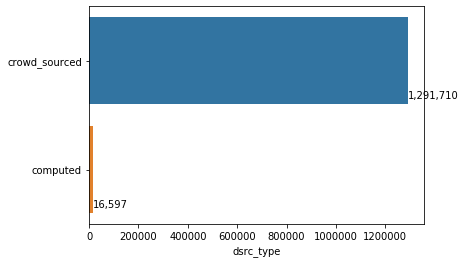

In [58]:
count_plot_h(edges['dsrc_type'])

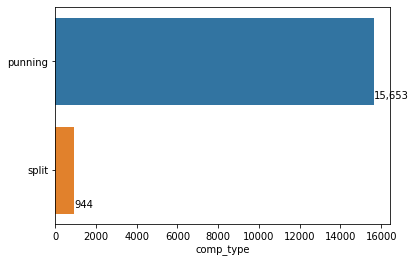

In [59]:
count_plot_h(edges['comp_type'])

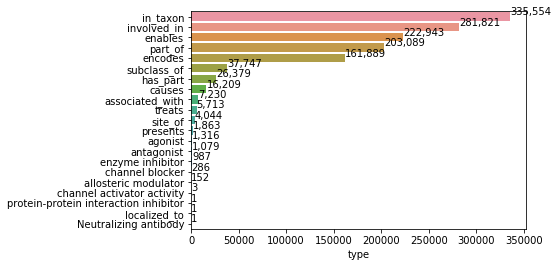

In [60]:
count_plot_h(edges['type'])

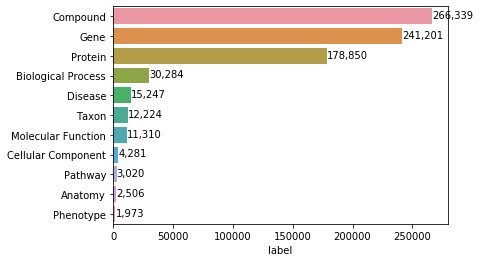

In [61]:
count_plot_h(nodes['label'])

In [62]:
combo = combine_nodes_and_edges(nodes, edges)

In [63]:
meta_edges = combo['start_label'] + '_' + combo['type'] + '_' + combo['end_label']
meta_edges.nunique()

47

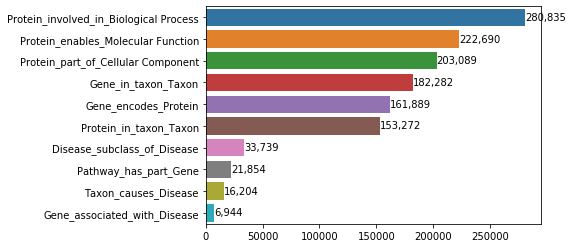

In [64]:
count_plot_h(meta_edges.value_counts().head(10))

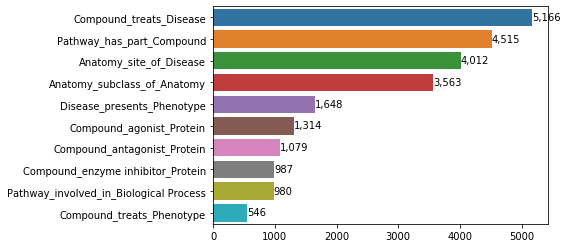

In [65]:
count_plot_h(meta_edges.value_counts().head(20).tail(10))

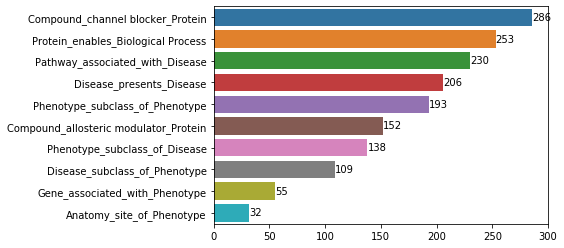

In [66]:
count_plot_h(meta_edges.value_counts().head(30).tail(10))

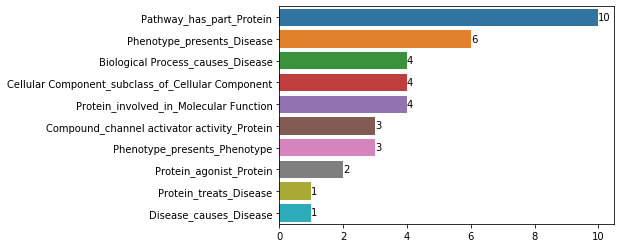

In [67]:
count_plot_h(meta_edges.value_counts().head(40).tail(10))

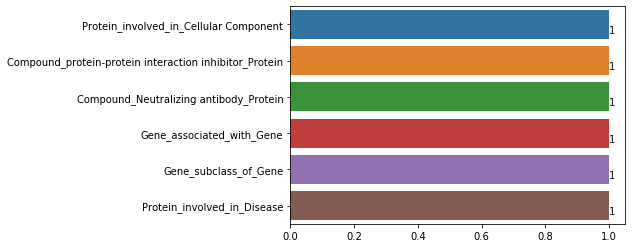

In [68]:
count_plot_h(meta_edges.value_counts().tail(6))

Many of the low count metaedges are either mistakes, or otherwise useless noisy edges:

Compound to protein edges are ok as they will later be changed to simplied semmantics:

One other should be examined:

- Disease Presents Diseases

This edge is of diseases that are also likely phenotypes, so we should have the proper phenotype in place instead of the disease

For now we will drop these edges...

In [69]:
drop_me = ['Protein_enables_Biological Process', 'Phenotype_subclass_of_Phenotype', 'Phenotype_subclass_of_Disease',
          'Disease_subclass_of_Phenotype', 'Phenotype_presents_Disease', 'Protein_involved_in_Molecular Function',
          'Cellular Component_subclass_of_Cellular Component', 'Phenotype_presents_Phenotype', 
          'Protein_agonist_Protein', 'Protein_involved_in_Cellular Component', 'Protein_involved_in_Disease',
          'Gene_associated_with_Gene', 'Gene_subclass_of_Gene', 'Disease_causes_Disease']

In [70]:
new_drop_index = meta_edges.rename('me').to_frame().query('me in @drop_me').index
len(new_drop_index)

717

### Now examine the Likely Disease Phenotype Edges...

In [71]:
dis_pheno_idx = combo.query('start_label == "Disease" and end_label == "Disease" and type != "subclass_of"').index

In [72]:
combo.loc[dis_pheno_idx].head(20)

,start_id,end_id,type,dsrc_type,comp_type,start_name,end_name,start_label,end_label
209,Q184627,Q1223924,causes,crowd_sourced,NaN,Human papillomavirus infection,papillomatosis,Disease,Disease
3725331,Q131755,Q2836,presents,crowd_sourced,NaN,bipolar disorder,mal payo,Disease,Disease
3725479,Q208562,Q174857,presents,crowd_sourced,NaN,Marfan syndrome,scoliosis,Disease,Disease
3725489,Q1404470,Q187255,presents,crowd_sourced,NaN,Felty's syndrome,rheumatoid arthritis,Disease,Disease
3725490,Q1404470,Q496812,presents,crowd_sourced,NaN,Felty's syndrome,leukopenia,Disease,Disease
3725491,Q2583514,Q496812,presents,crowd_sourced,NaN,Argentine hemorrhagic fever,leukopenia,Disease,Disease
3725493,Q7005033,Q174857,presents,crowd_sourced,NaN,Nevus comedonicus syndrome,scoliosis,Disease,Disease
3725496,Q28024539,Q174857,presents,crowd_sourced,NaN,NGLY1-deficiency,scoliosis,Disease,Disease
3725497,Q28024539,Q431643,presents,crowd_sourced,NaN,NGLY1-deficiency,microcephaly,Disease,Disease
3725503,Q79793,Q40878,presents,crowd_sourced,NaN,measles,diarrhea,Disease,Disease


In [73]:
likely_phenos = combo.loc[dis_pheno_idx]['end_id']

In [74]:
pheno_names = nodes.query('id in @likely_phenos')['name']
pheno_ids = nodes.query('name in @pheno_names and label == "Phenotype"')['id']
pheno_map = combo.query('start_label == "Disease" and end_id in @pheno_ids').set_index('start_id')['end_id'].to_dict()

In [75]:
edges.loc[dis_pheno_idx, 'end_id'] = edges.loc[dis_pheno_idx]['end_id'].map(pheno_map)

In [76]:
edges.loc[dis_pheno_idx]

,start_id,end_id,type,dsrc_type,comp_type
209,Q184627,NaN,causes,crowd_sourced,NaN
3725331,Q131755,HP:0002357,presents,crowd_sourced,NaN
3725479,Q208562,HP:0002650,presents,crowd_sourced,NaN
3725489,Q1404470,HP:0001370,presents,crowd_sourced,NaN
3725490,Q1404470,HP:0001882,presents,crowd_sourced,NaN
...,...,...,...,...,...
3726236,Q2836,HP:0007302,presents,crowd_sourced,NaN
3726237,Q911427,HP:0002102,presents,crowd_sourced,NaN
3726238,Q280156,HP:0000802,presents,crowd_sourced,NaN
3726240,Q408089,HP:0000822,presents,crowd_sourced,NaN


In [77]:
edges = edges.drop(new_drop_index)
edges = edges.dropna(subset=['end_id'])

In [78]:
combo = combine_nodes_and_edges(nodes, edges)

In [79]:
meta_edges = combo['start_label'] + '_' + combo['type'] + '_' + combo['end_label']
meta_edges.nunique()

32

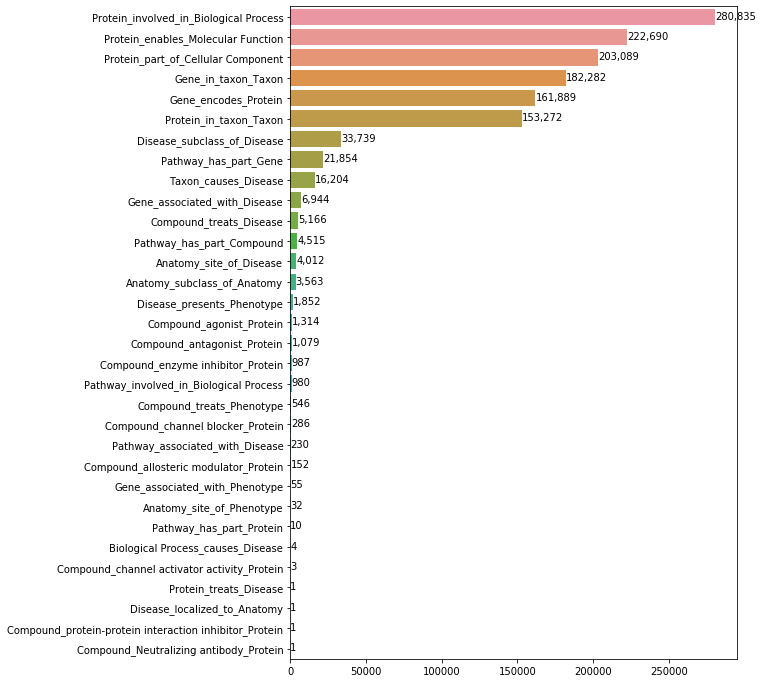

In [80]:
plt.figure(figsize=(8,12))
count_plot_h(meta_edges)

## Save out Resultant Edges

In [81]:
this_file = '01c_WikiData_Cleanup'
out_dir = Path('../2_pipeline/').joinpath(this_file, 'out').resolve()

out_dir.mkdir(parents=True, exist_ok=True)

nodes.to_csv(out_dir.joinpath('nodes.csv'), index=False)
edges.to_csv(out_dir.joinpath('edges.csv'), index=False)